In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

data = pd.read_csv("/content/drive/Shareddrives/1:1_Krishna_Vijay/Dataset/original/MSFT_dataset.csv")

In [3]:
# drop nulls
data.isnull().sum()
# select only required columns
UNWANTED_COLS = ["volume"]

# filter columns
df = data[[col for col in list(data.columns) if col not in UNWANTED_COLS]]
df.head()

,date,open,high,low,close
0,2013-02-08,27.35,27.71,27.31,27.55
1,2013-02-11,27.65,27.92,27.50,27.86
2,2013-02-12,27.88,28.00,27.75,27.88
3,2013-02-13,27.93,28.11,27.88,28.03
4,2013-02-14,27.92,28.06,27.87,28.04


In [4]:
# conver the data to pandas date time
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", drop = True, inplace = True)
df.head()

<ipython-input-4-76cabfe32200>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


,open,high,low,close
date,,,,
2013-02-08,27.35,27.71,27.31,27.55
2013-02-11,27.65,27.92,27.50,27.86
2013-02-12,27.88,28.00,27.75,27.88
2013-02-13,27.93,28.11,27.88,28.03
2013-02-14,27.92,28.06,27.87,28.04


In [5]:
df.to_csv("/content/drive/Shareddrives/1:1_Krishna_Vijay/Dataset/scaledNsplitted/MSFT_after_date_conversion.csv",index=False)

Time series plot

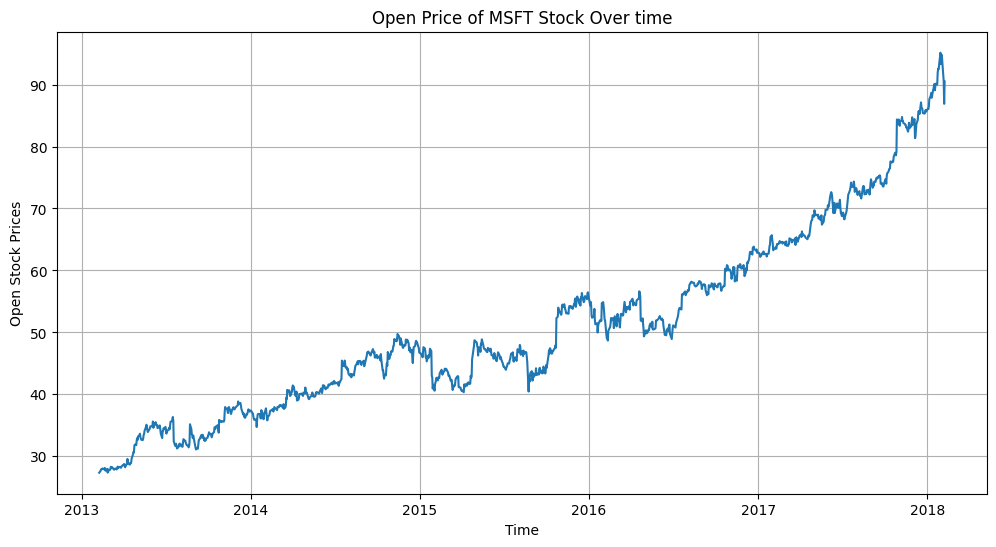

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
COMPANY = "MSFT"
plt.figure(figsize = (12,6))
plt.plot(df["open"])
plt.xlabel("Time")
plt.ylabel("Open Stock Prices")
plt.title("Open Price of {} Stock Over time".format(COMPANY))
plt.grid(True)
plt.show()

Preprocessing Using MinMaxScaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

MODEL_SAVE_PATH = "/content/drive/Shareddrives/1:1_Krishna_Vijay/Results/Models/"

COLUMNS = list(df.columns)
print("Columns", COLUMNS)

# fit the model
scaler = MinMaxScaler().fit(df[COLUMNS])
# save the model
with open(os.path.join(MODEL_SAVE_PATH, f"{COMPANY}scalermodel"), "wb") as tesla_model:
    pickle.dump(scaler, tesla_model)
    print("Model Saved")

# fot on data
df[COLUMNS] = scaler.transform(df[COLUMNS])

Columns ['open', 'high', 'low', 'close']
Model Saved


<ipython-input-7-3f0d68f0936a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[COLUMNS] = scaler.transform(df[COLUMNS])


In [8]:
df[COLUMNS]

,open,high,low,close
date,,,,
2013-02-08,0.000000,0.001607,0.001203,0.002661
2013-02-11,0.004425,0.004674,0.004061,0.007244
2013-02-12,0.007818,0.005842,0.007821,0.007540
2013-02-13,0.008556,0.007449,0.009776,0.009758
2013-02-14,0.008408,0.006718,0.009626,0.009905
...,...,...,...,...
2018-02-01,0.994837,1.000000,0.997914,0.988912
2018-02-02,0.977873,0.969330,0.966612,0.952247
2018-02-05,0.932438,0.958668,0.913972,0.896363


Splitting dataset

In [9]:
# define the plsit ratio
SPLIT_RATIO = 0.2

# train length
train_length = int(len(df) * (1 - SPLIT_RATIO))
print("train length", train_length)

train_data = df[:train_length]
test_data = df[train_length:]
print("train shape", train_data.shape)
print("test shape", test_data.shape)

train length 1007
train shape (1007, 4)
test shape (252, 4)


In [10]:
test_data.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

Saving scaled data to csv

In [11]:
train_data.to_csv("/content/drive/Shareddrives/1:1_Krishna_Vijay/Dataset/scaledNsplitted/MSFT_train_scaled.csv",index=False)
test_data.to_csv("/content/drive/Shareddrives/1:1_Krishna_Vijay/Dataset/scaledNsplitted/MSFT_test_scaled.csv",index=False)

In [12]:
import numpy as np

def prepare_seq(data,seq_len):    #eg seq=len = 50
    sequences,labels = [],[]
    #len of data is 1353 then 1353 - 50 is the range
    for i in range(len(data) - seq_len):
        #eg 0 to 50
        x_temp = data.iloc[i:i+seq_len].values
        #stores 50th value
        y_temp = data.iloc[i+seq_len].values

        sequences.append(x_temp)
        labels.append(y_temp)

    return np.array(sequences), np.array(labels)

In [13]:
# define the sequence length
SEQ_LENGTH = 50

# process the dataset
train_sequences,train_labels = prepare_seq(train_data, SEQ_LENGTH)
test_sequences,test_labels = prepare_seq(test_data, SEQ_LENGTH)
print(train_sequences.shape, test_sequences.shape)

(957, 50, 4) (202, 50, 4)


LSTM model creation

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.optimizers import Adam

# define the learning rate and epochs
LR = 0.001
EPOCHS = 50

# build the model
model = Sequential()
model.add(LSTM(units=50,return_sequences = True, input_shape=(train_sequences.shape[1],train_sequences.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(units = 50))
model.add(Dense(4))

# compile the model
model.compile(optimizer=Adam(learning_rate = LR), loss='mean_squared_error', metrics=['mean_squared_error'])

LSTM training

In [15]:
# train the model
model.fit(train_sequences,train_labels, epochs=EPOCHS, validation_data = (test_sequences,test_labels),verbose = 'auto')

Epoch 1/50
30/30 [==============================] - 7s 88ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 2/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 3/50
30/30 [==============================] - 3s 85ms/step - loss: 6.1567e-04 - mean_squared_error: 6.1567e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/50
30/30 [==============================] - 2s 81ms/step - loss: 5.6643e-04 - mean_squared_error: 5.6643e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 5/50
30/30 [==============================] - 1s 48ms/step - loss: 5.4616e-04 - mean_squared_error: 5.4616e-04 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/50
30/30 [==============================] - 1s 50ms/step - loss: 5.2244e-04 - mean_squared_error: 5.2244e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Ep

Saving best model LSTM





In [16]:
SAVE = True
LSTM_MODEL_PATH = "/content/drive/Shareddrives/1:1_Krishna_Vijay/Results/Models/"

# save the model if needed
if SAVE:
    model.save(os.path.join(LSTM_MODEL_PATH, f"best_model_{COMPANY}_LSTM.h5"))
    print("Model is saved")

Model is saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


GRU model creation

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,Dropout
from tensorflow.keras.optimizers import Adam

# define the learning rate and epochs
LR = 0.001
EPOCHS = 50

# build the model
model_GRU = Sequential()
model_GRU.add(GRU(units=50,return_sequences = True, input_shape=(train_sequences.shape[1],train_sequences.shape[2])))
model_GRU.add(Dropout(0.1))
model_GRU.add(GRU(units = 50))
model_GRU.add(Dense(4))

# compile the model
model_GRU.compile(optimizer=Adam(learning_rate = LR), loss='mean_squared_error', metrics=['mean_squared_error'])

Training GRU

In [18]:
# train the model
model_GRU.fit(train_sequences,train_labels, epochs=EPOCHS, validation_data = (test_sequences,test_labels),verbose = 'auto')

Epoch 1/50
30/30 [==============================] - 10s 153ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2/50
30/30 [==============================] - 3s 93ms/step - loss: 9.0651e-04 - mean_squared_error: 9.0651e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/50
30/30 [==============================] - 2s 57ms/step - loss: 4.6018e-04 - mean_squared_error: 4.6018e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/50
30/30 [==============================] - 2s 52ms/step - loss: 4.0219e-04 - mean_squared_error: 4.0219e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/50
30/30 [==============================] - 2s 50ms/step - loss: 3.9363e-04 - mean_squared_error: 3.9363e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 6/50
30/30 [==============================] - 2s 52ms/step - loss: 3.9783e-04 - mean_squared_error: 3.9783e-04 - val_loss: 0.0013 - val_mean_squared_error:

Saving best GRU model

In [19]:
SAVE = True
GRU_MODEL_PATH = "/content/drive/Shareddrives/1:1_Krishna_Vijay/Results/Models/"

# save the model if needed
if SAVE:
    model_GRU.save(os.path.join(GRU_MODEL_PATH, f"best_model_{COMPANY}_GRU.h5"))
    print("Model is saved")

Model is saved
